## Notebook for model independent templates 

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
import scipy
import scipy.interpolate as interpolate

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
path = f'{os.path.split(os.getcwd())[0]}/../'
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(path)
    
# module that imports MB data and defines the MB chi2, etc (neutrino data only)
from HarvardPerimeter import miniboone_neutrino_improved_fit as mbfit

# module with MCMC tools using model-independent template
from HarvardPerimeter import mcmc_signal
from HarvardPerimeter.mcmc_signal import get_pvalue

# module for plotting
from HarvardPerimeter import plot_tools

## Test chi2 function


We start by testing our MiniBooNE chi2 function. We take the LEE, defined as (data - background) for the MiniBooNE 2018 neutrino dataset, and deform its shape by taking events from the first 2 bins, and distributing them evenly across the other bins

In [4]:
PATH_PLOTS = '../../../plots/'

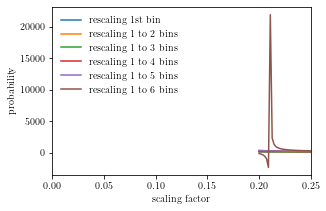

In [176]:
fig, ax = plot_tools.std_fig()

xmin=1
ax.plot(*mcmc_signal.get_templates_for_all_scalings(xrange = [0.2, 2], n=1), label=r'rescaling 1st bin')
ax.plot(*mcmc_signal.get_templates_for_all_scalings(xrange = [0.2, 2], n=2), label=r'rescaling 1 to 2 bins')
ax.plot(*mcmc_signal.get_templates_for_all_scalings(xrange = [0.2, 2], n=3), label=r'rescaling 1 to 3 bins')
ax.plot(*mcmc_signal.get_templates_for_all_scalings(xrange = [0.2, 2], n=4), label=r'rescaling 1 to 4 bins')
ax.plot(*mcmc_signal.get_templates_for_all_scalings(xrange = [0.2, 2], n=5), label=r'rescaling 1 to 5 bins')
ax.plot(*mcmc_signal.get_templates_for_all_scalings(xrange = [0.2, 2], n=6), label=r'rescaling 1 to 6 bins')

ax.set_ylabel(r"probability")
ax.set_xlabel(r"scaling factor")
ax.legend()
fig.savefig(f"{PATH_PLOTS}/trial_templates_chi2.png", dpi=400)

### Now we check that Pedro's example gives p-value = 10%

In [177]:
# took pedro's values by eye/
pedros_template = np.array([35,42,67,50,40,40,43,40,30,0,0])
pedros_chi2 = mbfit.CalculateChi2SignalExpectations(pedros_template)
pedros_pvalue = scipy.stats.chi2.sf(pedros_chi2, 8.7, loc=0, scale=1)
print("Pedro's template p-value:", pedros_pvalue)

Pedro's template p-value: 0.10134747397854528


In [178]:
bestfit_x = 0
bestfit_p = 0
for x in np.geomspace(0.01,10,1000):
    flat_template = x*mbfit.bin_width
    flat_template[-1:] = 0.0
    if mcmc_signal.get_pvalue(flat_template) > bestfit_p:
        bestfit_x = x
        bestfit_p = mcmc_signal.get_pvalue(flat_template)
print(f"Best flat template has {bestfit_x} events in each bin, with p-value={bestfit_p}")

# now we keep the best template
flat_template = bestfit_x*mbfit.bin_width 
flat_template[-1] = 0

Best flat template has 0.19828839491270714 events in each bin, with p-value=0.11154757703378755


##### yet another template by reducing first 4 bins by a factor of 3

In [237]:
template_1=mcmc_signal.new_template(3, n=4)
mbfit.CalculateChi2SignalExpectations(template_1)
template_1_pvalue = scipy.stats.chi2.sf(mbfit.CalculateChi2SignalExpectations(template_1), 
                                        len(template_1)-1)
print(template_1_pvalue)
print(np.sum(template_1))

0.009219081991035754
359.874622


In [245]:
# template_1=mcmc_signal.new_template(3, n=4)
# mbfit.CalculateChi2SignalExpectations(template_1)
# template_1_pvalue = scipy.stats.chi2.sf(mbfit.CalculateChi2SignalExpectations(template_1), 
#                                         len(template_1)-1)

test = mcmc_11bins_free

test_normed =test.T[ np.abs(np.sum(test, axis=0) - 359.874622) < 5]
e_test = np.sum((test_normed*mbfit.bin_centers).T/359.874622, axis=0)

template_1 = test_normed[np.argmax(test_normed[:,0])]


### Plot some templates on top of MiniBooNE data

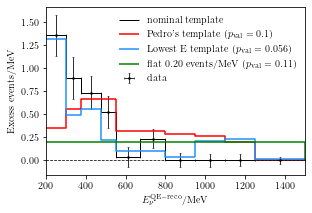

In [248]:
fig, ax = plot_tools.std_fig()

# plot data
plot_tools.data_plot(ax, 
          X=mbfit.bin_centers,
          Y=(mbfit.mb_nominal_excess)/mbfit.bin_width, 
          xerr=np.diff(mbfit.bin_edges)/2, 
          yerr=np.sqrt(mbfit.mb_nue_analysis_data)/mbfit.bin_width,
            zorder=1)

# # plot signal
MB_LEE = mbfit.mb_nue_analysis_data - mbfit.mb_nue_analysis_predicted_background
plot_tools.step_plot(ax, 
              x=mbfit.bin_edges[:-1],
              y=(mbfit.mb_nominal_excess)/mbfit.bin_width,
              color='black',
              label='nominal template')


# PEDRO
plot_tools.step_plot(ax,
              x=mbfit.bin_edges[:-1],
              y=(pedros_template)/mbfit.bin_width,
              color='red',lw=1.5,
              label=fr"Pedro's template ($p_{{\rm val}} = {get_pvalue(pedros_template):.2g}$)")


# MINE
plot_tools.step_plot(ax,
              x=mbfit.bin_edges[:-1],
              y=(template_1)/mbfit.bin_width,
              color='dodgerblue',lw=1.5,
              label=fr'Lowest E template ($p_{{\rm val}} = {get_pvalue(template_1):.2g}$)')

# FLAT
plot_tools.step_plot(ax,
              x=mbfit.bin_edges[:-1],
              y=(flat_template)/mbfit.bin_width,
              color='green',lw=1.5,
              label=fr"\noindent flat {bestfit_x:.2f} events/MeV ($p_{{\rm val}} = {get_pvalue(flat_template):.2g}$)")


ax.legend()
ax.set_xlabel(r"$E^{\rm QE-reco}_\nu/{\rm MeV}$")
ax.set_ylabel(r"Excess events/MeV")
ax.set_xlim(200.0,1.5e3)
ax.hlines(0,0,2e3, lw=0.75, ls='--', color='black')
# ax.set_ylim(-0.1,3)

fig.savefig(f"{PATH_PLOTS}/trial_templates.png", dpi=400)

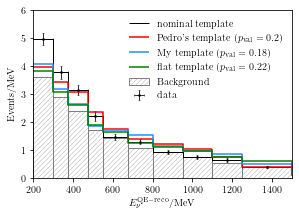

In [14]:
fig, ax = plot_tools.std_fig()

# plot data
plot_tools.data_plot(ax, 
          X=mbfit.bin_centers,
          Y=(mbfit.mb_nue_analysis_data)/mbfit.bin_width, 
          xerr=np.diff(mbfit.bin_edges)/2, 
          yerr=np.sqrt(mbfit.mb_nue_analysis_data)/mbfit.bin_width,
         zorder=1)

# # plot signal
MB_LEE = mbfit.mb_nue_analysis_data - mbfit.mb_nue_analysis_predicted_background
plot_tools.step_plot(ax, 
              x=mbfit.bin_edges[:-1],
              y=(MB_LEE+mbfit.mb_nue_analysis_predicted_background)/mbfit.bin_width,
              color='black',
              label='nominal template')

template_1= mcmc_signal.new_template(3, 4)
mbfit.CalculateChi2SignalExpectations(template_1)
template_1_pvalue = scipy.stats.chi2.sf(mbfit.CalculateChi2SignalExpectations(template_1), 
                                        len(template_1)-1)



# PEDRO
plot_tools.step_plot(ax,
              x=mbfit.bin_edges[:-1],
              y=(pedros_template+mbfit.mb_nue_analysis_predicted_background)/mbfit.bin_width,
              color='red',lw=1.5,
              label=fr"Pedro's template ($p_{{\rm val}} = {get_pvalue(pedros_template):.2g}$)")

# MINE
plot_tools.step_plot(ax,
              x=mbfit.bin_edges[:-1],
              y=(template_1+mbfit.mb_nue_analysis_predicted_background)/mbfit.bin_width,
              color='dodgerblue',lw=1.5,
              label=fr'My template ($p_{{\rm val}} = {get_pvalue(template_1):.2g}$)')
# FLAT TEMPLATE
plot_tools.step_plot(ax,
              x=mbfit.bin_edges[:-1],
              y=(flat_template+mbfit.mb_nue_analysis_predicted_background)/mbfit.bin_width,
              color='green',lw=1.5,
              label=fr"flat template ($p_{{\rm val}} = {get_pvalue(flat_template):.2g}$)")


ax.hist(mbfit.bin_centers,
         weights=mbfit.mb_nue_analysis_predicted_background/mbfit.bin_width,
         bins=mbfit.bin_edges, 
         lw = 1, 
        hatch='/////',
        facecolor = "None", 
        edgecolor='grey',
         label = "Background")

ax.legend()
ax.set_xlabel(r"$E^{\rm QE-reco}_\nu/{\rm MeV}$")
ax.set_ylabel(r"Events/MeV")
ax.set_xlim(200.0,1.5e3)
ax.hlines(0,0,2e3, lw=0.75, ls='--', color='black')
ax.set_ylim(0,6)

fig.savefig(f"{PATH_PLOTS}/trial_templates_w_bkgs.png", dpi=400)

# Run MCMC 

##### test likelihood function that will be used in mcmc 

In [15]:
print(mcmc_signal.GetLikelihood(flat_template),
      mcmc_signal.lnprior(flat_template), 
      mcmc_signal.lnprob(flat_template))

print(mcmc_signal.GetLikelihood(pedros_template), 
      mcmc_signal.lnprior(pedros_template), 
      mcmc_signal.lnprob(pedros_template))

print(mcmc_signal.GetLikelihood(template_1), 
      mcmc_signal.lnprior(template_1), 
      mcmc_signal.lnprob(template_1))

-6.9626267931395285 -inf -inf
-7.1224152621102075 -inf -inf
-7.34563552578528 2.0379360524449073 -5.307699473340373


### Trial run w/ only 4 lowest-energy bins

setting other high energy bins to 0

In [16]:
# start with only 4 first bins
_=mcmc_signal.run_mcmc(nwalkers=16, nsteps = 1000, threads=4, burnin_steps = 500, nbins=4)


/usr/local/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 26%|██▌       | 130/500 [00:00<00:00, 1296.00it/s]

Initializing walkers
Running burn-in


 16%|█▋        | 164/1000 [00:00<00:00, 1635.08it/s]

Running proper mcmc


100%|██████████| 1000/1000 [00:00<00:00, 1766.74it/s]


Time elapsed 0.9033710956573486


In [17]:
_=mcmc_signal.run_mcmc(nwalkers=16, nsteps = 100, nbins=4, normalize=True)

/usr/local/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 4/1000 [00:00<00:27, 35.79it/s]

Initializing walkers
Running burn-in


100%|██████████| 100/100 [00:00<00:00, 622.42it/s]


Running proper mcmc
Time elapsed 2.4657840728759766


### first 10 BINS


In [18]:
## neglecting the overflow bin for comparison
_=mcmc_signal.run_mcmc(nwalkers=50, nsteps = 1000, nbins=10)

/usr/local/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  9%|▉         | 93/1000 [00:00<00:00, 926.68it/s]

Initializing walkers
Running burn-in


  8%|▊         | 83/1000 [00:00<00:01, 826.26it/s]

Running proper mcmc


100%|██████████| 1000/1000 [00:01<00:00, 939.71it/s]


Time elapsed 2.2860031127929688


In [40]:
_=mcmc_signal.run_mcmc(nwalkers=50, nsteps = 1000, nbins=10, normalize=True)

/usr/local/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 20/1000 [00:00<00:05, 189.94it/s]

Initializing walkers
Running burn-in


  2%|▏         | 19/1000 [00:00<00:05, 188.54it/s]

Running proper mcmc


100%|██████████| 1000/1000 [00:04<00:00, 240.88it/s]


Time elapsed 8.280052900314331


### All 11 bins

In [95]:
_=mcmc_signal.run_mcmc(nwalkers=55, nsteps = 1000, nbins=11)

  2%|▏         | 20/1000 [00:00<00:04, 197.74it/s]

Initializing walkers
Running burn-in


  2%|▏         | 21/1000 [00:00<00:04, 204.83it/s]

Running proper mcmc


100%|██████████| 1000/1000 [00:03<00:00, 309.62it/s]


Time elapsed 6.574086904525757


In [21]:
_=mcmc_signal.run_mcmc(nwalkers=55, nsteps = 2000, nbins=11, normalize=True)

  1%|          | 9/1000 [00:00<00:12, 82.28it/s]

Initializing walkers
Running burn-in


  1%|          | 14/2000 [00:00<00:14, 137.36it/s]

Running proper mcmc


100%|██████████| 2000/2000 [00:08<00:00, 228.85it/s]


Time elapsed 13.710517883300781


### load mcmc samples

In [41]:
mcmc_11bins_norm = np.genfromtxt('../mcmc_results/miniboone_signal_chain_11_bins_normalized.dat',unpack=True)
mcmc_10bins_norm = np.genfromtxt('../mcmc_results/miniboone_signal_chain_10_bins_normalized.dat',unpack=True)
mcmc_4bins_norm = np.genfromtxt('../mcmc_results/miniboone_signal_chain_4_bins_normalized.dat',unpack=True)

In [56]:
filtered_mcmc_4bins_norm = mcmc_signal.filter_samples(mcmc_4bins_norm)
filtered_mcmc_10bins_norm = mcmc_signal.filter_samples(mcmc_10bins_norm)
filtered_mcmc_11bins_norm = mcmc_signal.filter_samples(mcmc_11bins_norm)

In [96]:
mcmc_11bins_free = np.genfromtxt('../mcmc_results/miniboone_signal_chain_11_bins_free.dat',unpack=True)
filtered_mcmc_11bins_free = mcmc_signal.filter_samples(mcmc_11bins_free)

In [24]:
mcmc_11bins_free = np.genfromtxt('../mcmc_results/miniboone_signal_chain_11_bins_free.dat',unpack=True)
mcmc_10bins_free = np.genfromtxt('../mcmc_results/miniboone_signal_chain_10_bins_free.dat',unpack=True)
mcmc_4bins_free = np.genfromtxt('../mcmc_results/miniboone_signal_chain_4_bins_free.dat',unpack=True)


filtered_mcmc_4bins_free = mcmc_signal.filter_samples(mcmc_4bins_free)
filtered_mcmc_10bins_free = mcmc_signal.filter_samples(mcmc_10bins_free)
filtered_mcmc_11bins_free = mcmc_signal.filter_samples(mcmc_11bins_free)

In [57]:
print("free: ", np.shape(filtered_mcmc_4bins_free)[1]/np.shape(mcmc_4bins_free)[1])
print("free: ", np.shape(filtered_mcmc_10bins_free)[1]/np.shape(mcmc_10bins_free)[1])
print("free: ", np.shape(filtered_mcmc_11bins_free)[1]/np.shape(mcmc_11bins_free)[1])

print("\nnormed: ", np.shape(filtered_mcmc_4bins_norm)[1]/np.shape(mcmc_4bins_norm)[1])
print("normed: ", np.shape(filtered_mcmc_10bins_norm)[1]/np.shape(mcmc_10bins_norm)[1])
print("normed: ", np.shape(filtered_mcmc_11bins_norm)[1]/np.shape(mcmc_11bins_norm)[1])

free:  0.0
free:  1.0
free:  0.19761818181818183

normed:  0.0
normed:  0.33772
normed:  0.17608181818181817


### total number of excess events in each tempalte

In [97]:
nevents_11bins_norm = np.sum(mcmc_11bins_norm,axis=0)
nevents_10bins_norm = np.sum(mcmc_10bins_norm,axis=0)
nevents_4bins_norm = np.sum(mcmc_4bins_norm,axis=0)

filtered_nevents_11bins_norm = np.sum(filtered_mcmc_11bins_norm,axis=0)
filtered_nevents_10bins_norm = np.sum(filtered_mcmc_10bins_norm,axis=0)
filtered_nevents_4bins_norm = np.sum(filtered_mcmc_4bins_norm,axis=0)


nevents_11bins_free = np.sum(mcmc_11bins_free,axis=0)
nevents_10bins_free = np.sum(mcmc_10bins_free,axis=0)
nevents_4bins_free = np.sum(mcmc_4bins_free,axis=0)

filtered_nevents_11bins_free = np.sum(filtered_mcmc_11bins_free,axis=0)
filtered_nevents_10bins_free = np.sum(filtered_mcmc_10bins_free,axis=0)
filtered_nevents_4bins_free = np.sum(filtered_mcmc_4bins_free,axis=0)

### average energy of the template

In [98]:
avg_energy_4bins_norm = np.sum((mcmc_4bins_norm.T*mbfit.bin_centers).T/nevents_4bins_norm,axis=0)
avg_energy_10bins_norm = np.sum((mcmc_10bins_norm.T*mbfit.bin_centers).T/nevents_10bins_norm,axis=0)
avg_energy_11bins_norm = np.sum((mcmc_11bins_norm.T*mbfit.bin_centers).T/nevents_11bins_norm,axis=0)

filtered_avg_energy_4bins_norm = np.sum((filtered_mcmc_4bins_norm.T*mbfit.bin_centers).T/filtered_nevents_4bins_norm,axis=0)
filtered_avg_energy_10bins_norm = np.sum((filtered_mcmc_10bins_norm.T*mbfit.bin_centers).T/filtered_nevents_10bins_norm,axis=0)
filtered_avg_energy_11bins_norm = np.sum((filtered_mcmc_11bins_norm.T*mbfit.bin_centers).T/filtered_nevents_11bins_norm,axis=0)


avg_energy_4bins_free = np.sum((mcmc_4bins_free.T*mbfit.bin_centers).T/nevents_4bins_free,axis=0)
avg_energy_10bins_free = np.sum((mcmc_10bins_free.T*mbfit.bin_centers).T/nevents_10bins_free,axis=0)
avg_energy_11bins_free = np.sum((mcmc_11bins_free.T*mbfit.bin_centers).T/nevents_11bins_free,axis=0)

filtered_avg_energy_4bins_free = np.sum((filtered_mcmc_4bins_free.T*mbfit.bin_centers).T/filtered_nevents_4bins_free,axis=0)
filtered_avg_energy_10bins_free = np.sum((filtered_mcmc_10bins_free.T*mbfit.bin_centers).T/filtered_nevents_10bins_free,axis=0)
filtered_avg_energy_11bins_free = np.sum((filtered_mcmc_11bins_free.T*mbfit.bin_centers).T/filtered_nevents_11bins_free,axis=0)

## time lapse of mcmc

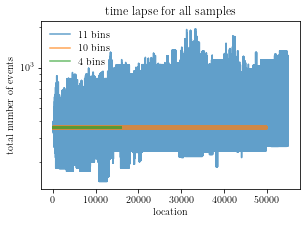

In [99]:
fig,ax = plot_tools.std_fig()

ax.plot(nevents_11bins_free, label='11 bins', alpha=0.7)
ax.plot(nevents_10bins_free, label='10 bins', alpha=0.7)
ax.plot(nevents_4bins_free, label='4 bins', alpha=0.7)
ax.legend()
ax.set_xlabel("location")
ax.set_ylabel("total number of events")
ax.set_yscale('log')
ax.set_title("time lapse for all samples")
fig.savefig("../mcmc_results/time_lapse_free.png", dpi=400)

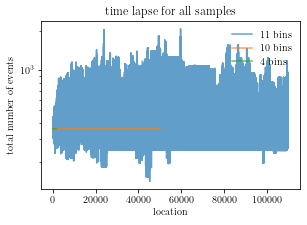

In [100]:
fig,ax = plot_tools.std_fig()

ax.plot(nevents_11bins_norm, label='11 bins', alpha=0.7)
ax.plot(nevents_10bins_norm, label='10 bins', alpha=0.7)
ax.plot(nevents_4bins_norm, label='4 bins', alpha=0.7)
ax.legend()
ax.set_xlabel("location")
ax.set_ylabel("total number of events")
ax.set_yscale('log')
ax.set_title("time lapse for all samples")
fig.savefig("../mcmc_results/time_lapse_norm.png", dpi=400)

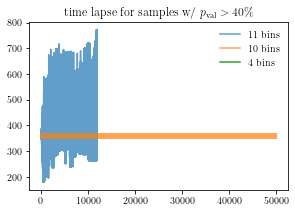

In [101]:
fig,ax = plot_tools.std_fig()

ax.plot(filtered_nevents_11bins_free, label='11 bins', alpha=0.7)
ax.plot(filtered_nevents_10bins_free, label='10 bins', alpha=0.7)
ax.plot(filtered_nevents_4bins_free, label='4 bins', alpha=1, zorder=10)
ax.legend()
ax.set_title(r"time lapse for samples w/ $p_{\rm val}>40\%$")
fig.savefig("../mcmc_results/time_lapse_free.png", dpi=400)

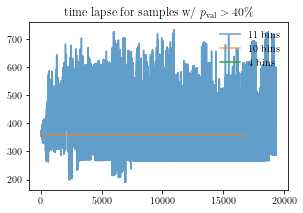

In [102]:
fig,ax = plot_tools.std_fig()

ax.plot(filtered_nevents_11bins_norm, label='11 bins', alpha=0.7)
ax.plot(filtered_nevents_10bins_norm, label='10 bins', alpha=0.7)
ax.plot(filtered_nevents_4bins_norm, label='4 bins', alpha=1, zorder=10)
ax.legend()
ax.set_title(r"time lapse for samples w/ $p_{\rm val}>40\%$")
fig.savefig("../mcmc_results/time_lapse_norm.png", dpi=400)

## Distribution of excess events

359.87462199999993


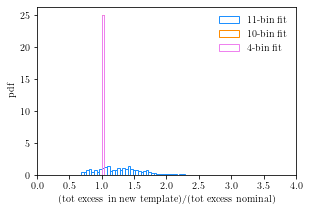

In [103]:
fig, ax = plot_tools.std_fig()


XMIN = 0
XMAX = 4

tot_excess_LEE=np.sum(MB_LEE)
print(tot_excess_LEE)


_=ax.hist(nevents_11bins_norm/tot_excess_LEE, range=(XMIN,XMAX), bins=100, label=r'11-bin fit',
          facecolor='None', edgecolor='dodgerblue', density=True)
_=ax.hist(nevents_10bins_norm/tot_excess_LEE, range=(XMIN,XMAX), bins=100, label=r'10-bin fit',
          facecolor='None', edgecolor='darkorange', density=True)
_=ax.hist(nevents_4bins_norm/tot_excess_LEE, range=(XMIN,XMAX), bins=100, label=r'4-bin fit',
          facecolor='None', edgecolor='violet', density=True)

ax.legend()
ax.set_xlabel(r"(tot excess in new template)/(tot excess nominal)")
ax.set_ylabel(r"pdf")
ax.set_xlim(XMIN,XMAX)
fig.savefig(f'{PATH_PLOTS}/histogram_nevents.png', dpi=400)



/usr/local/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


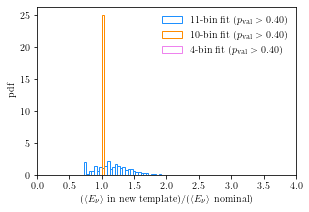

In [52]:
fig, ax = plot_tools.std_fig()


XMIN = 0
XMAX = 4

_=ax.hist(filtered_nevents_11bins_norm/tot_excess_LEE, range=(XMIN,XMAX), bins=100, label=r'11-bin fit ($p_{\rm val} > 0.40$)',
          facecolor='None', edgecolor='dodgerblue', density=True)
_=ax.hist(filtered_nevents_10bins_norm/tot_excess_LEE, range=(XMIN,XMAX), bins=100, label=r'10-bin fit ($p_{\rm val} > 0.40$)',
          facecolor='None', edgecolor='darkorange', density=True)
_=ax.hist(filtered_nevents_4bins_norm/tot_excess_LEE, range=(XMIN,XMAX), bins=100, label=r'4-bin fit ($p_{\rm val} > 0.40$)',
          facecolor='None', edgecolor='violet', density=True)


ax.legend()
ax.set_xlabel(r"($\langle E_\nu \rangle$ in new template)/($\langle E_\nu \rangle$ nominal)")
ax.set_ylabel(r"pdf")
ax.set_xlim(XMIN,XMAX)
fig.savefig(f'{PATH_PLOTS}/histogram_nevents_filtered.png', dpi=400)



### histogram average energy

374.83741500810805


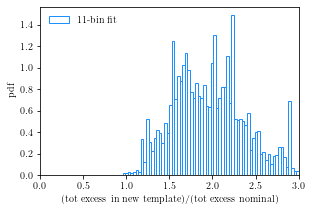

In [104]:
fig, ax = plot_tools.std_fig()


XMIN = 0
XMAX = 3

avg_energy_LEE=np.sum(MB_LEE*mbfit.bin_centers)/np.sum(MB_LEE)
print(avg_energy_LEE)


_=ax.hist(avg_energy_11bins_free/avg_energy_LEE, range=(XMIN,XMAX), bins=100, label=r'11-bin fit',
          facecolor='None', edgecolor='dodgerblue', density=True)
# _=ax.hist(avg_energy_10bins_free/avg_energy_LEE, range=(XMIN,XMAX), bins=100, label=r'10-bin fit',
#           facecolor='None', edgecolor='darkorange', density=True)
# _=ax.hist(avg_energy_4bins_free/avg_energy_LEE, range=(XMIN,XMAX), bins=100, label=r'4-bin fit',
#           facecolor='None', edgecolor='violet', density=True)

ax.legend()
ax.set_xlabel(r"(tot excess in new template)/(tot excess nominal)")
ax.set_ylabel(r"pdf")
ax.set_xlim(XMIN,XMAX)
fig.savefig(f'{PATH_PLOTS}/histogram_avg_enu_free.png', dpi=400)



374.83741500810805


/usr/local/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


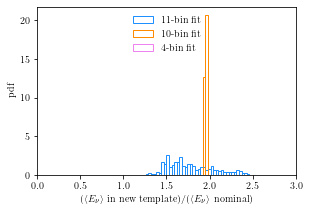

In [37]:
fig, ax = plot_tools.std_fig()


XMIN = 0
XMAX = 3

avg_energy_LEE=np.sum(MB_LEE*mbfit.bin_centers)/np.sum(MB_LEE)
print(avg_energy_LEE)


_=ax.hist(filtered_avg_energy_11bins_free/avg_energy_LEE, range=(XMIN,XMAX), bins=100, label=r'11-bin fit',
          facecolor='None', edgecolor='dodgerblue', density=True)
_=ax.hist(filtered_avg_energy_10bins_free/avg_energy_LEE, range=(XMIN,XMAX), bins=100, label=r'10-bin fit',
          facecolor='None', edgecolor='darkorange', density=True)
_=ax.hist(filtered_avg_energy_4bins_free/avg_energy_LEE, range=(XMIN,XMAX), bins=100, label=r'4-bin fit',
          facecolor='None', edgecolor='violet', density=True)

ax.legend()
ax.set_xlabel(r"($\langle E_\nu \rangle$ in new template)/($\langle E_\nu \rangle$ nominal)")
ax.set_ylabel(r"pdf")
ax.set_xlim(XMIN,XMAX)
fig.savefig(f'{PATH_PLOTS}/histogram_avg_enu_filtered_free.png', dpi=400)



374.83741500810805


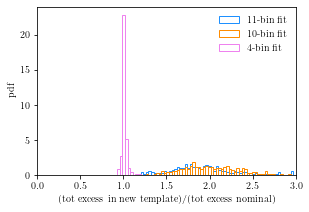

In [38]:
fig, ax = plot_tools.std_fig()


XMIN = 0
XMAX = 3

avg_energy_LEE=np.sum(MB_LEE*mbfit.bin_centers)/np.sum(MB_LEE)
print(avg_energy_LEE)


_=ax.hist(avg_energy_11bins_norm/avg_energy_LEE, range=(XMIN,XMAX), bins=100, label=r'11-bin fit',
          facecolor='None', edgecolor='dodgerblue', density=True)
_=ax.hist(avg_energy_10bins_norm/avg_energy_LEE, range=(XMIN,XMAX), bins=100, label=r'10-bin fit',
          facecolor='None', edgecolor='darkorange', density=True)
_=ax.hist(avg_energy_4bins_norm/avg_energy_LEE, range=(XMIN,XMAX), bins=100, label=r'4-bin fit',
          facecolor='None', edgecolor='violet', density=True)

ax.legend()
ax.set_xlabel(r"(tot excess in new template)/(tot excess nominal)")
ax.set_ylabel(r"pdf")
ax.set_xlim(XMIN,XMAX)
fig.savefig(f'{PATH_PLOTS}/histogram_avg_enu_norm.png', dpi=400)



374.83741500810805


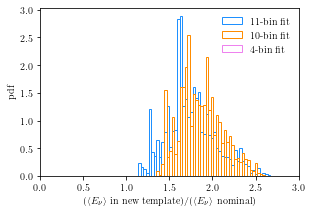

In [39]:
fig, ax = plot_tools.std_fig()


XMIN = 0
XMAX = 3

avg_energy_LEE=np.sum(MB_LEE*mbfit.bin_centers)/np.sum(MB_LEE)
print(avg_energy_LEE)


_=ax.hist(filtered_avg_energy_11bins_norm/avg_energy_LEE, range=(XMIN,XMAX), bins=100, label=r'11-bin fit',
          facecolor='None', edgecolor='dodgerblue', density=True)
_=ax.hist(filtered_avg_energy_10bins_norm/avg_energy_LEE, range=(XMIN,XMAX), bins=100, label=r'10-bin fit',
          facecolor='None', edgecolor='darkorange', density=True)
_=ax.hist(filtered_avg_energy_4bins_norm/avg_energy_LEE, range=(XMIN,XMAX), bins=100, label=r'4-bin fit',
          facecolor='None', edgecolor='violet', density=True)

ax.legend()
ax.set_xlabel(r"($\langle E_\nu \rangle$ in new template)/($\langle E_\nu \rangle$ nominal)")
ax.set_ylabel(r"pdf")
ax.set_xlim(XMIN,XMAX)
fig.savefig(f'{PATH_PLOTS}/histogram_avg_enu_filtered_norm.png', dpi=400)


### define a function that gets the n highest energy templates (largest <Enu>)

## Plot tempates side by side with LEE

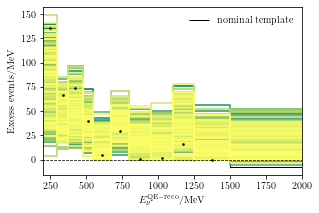

In [60]:
fig, ax = plot_tools.std_fig()
units = mbfit.bin_width
# plot data
plot_tools.data_plot(ax, 
          X=mbfit.bin_centers,
          Y=(mbfit.mb_nue_analysis_data-mbfit.mb_nue_analysis_predicted_background)/mbfit.bin_width*units, 
          xerr=np.diff(mbfit.bin_edges)/2, 
          yerr=np.sqrt(mbfit.mb_nue_analysis_data)/mbfit.bin_width, label='',
            zorder=1)

# # plot signal
MB_LEE = mbfit.mb_nue_analysis_data - mbfit.mb_nue_analysis_predicted_background
plot_tools.step_plot(ax, 
              x=mbfit.bin_edges[:-1],
              y=(MB_LEE)/mbfit.bin_width*units,
              color='black',
              label='nominal template')


# Loop over mcmc templates
mcmc_templates = filtered_mcmc_10bins_norm
n=500
color = iter(cm.summer(np.linspace(0, 1, n)))
for i_template in np.random.choice(np.shape(mcmc_templates)[1], size=n):
    template = mcmc_templates[:,i_template]
    c = next(color)
    plot_tools.step_plot(ax,
                  x=mbfit.bin_edges[:-1],
                  y=(template)/mbfit.bin_width*units,
                  color=c,  lw=1.5,
                  label='')
#                   label=fr"\#${i_template}$, $p_{{\rm val}} = {get_pvalue(template):.2g}$")

ax.legend()
ax.set_xlabel(r"$E^{\rm QE-reco}_\nu/{\rm MeV}$")
ax.set_ylabel(r"Excess events/MeV")
ax.set_xlim(200.0,2e3)
ax.hlines(0,0,2e3, lw=0.75, ls='--', color='black')
# ax.set_ylim(-0.1,2)

fig.savefig(f'{PATH_PLOTS}/mcmc_templates_10bins.png', dpi=400)
fig.savefig(f'{PATH_PLOTS}/mcmc_templates.pdf', dpi=400)

### Now plot only the highest energy ones

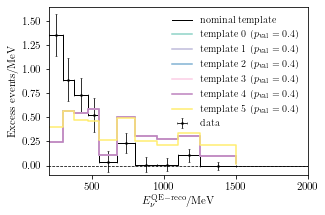

In [55]:
fig, ax = plot_tools.std_fig()

# plot data
plot_tools.data_plot(ax, 
          X=mbfit.bin_centers,
          Y=(mbfit.mb_nue_analysis_data-mbfit.mb_nue_analysis_predicted_background)/mbfit.bin_width, 
          xerr=np.diff(mbfit.bin_edges)/2, 
          yerr=np.sqrt(mbfit.mb_nue_analysis_data)/mbfit.bin_width,
            zorder=1)

# # plot signal
MB_LEE = mbfit.mb_nue_analysis_data - mbfit.mb_nue_analysis_predicted_background
plot_tools.step_plot(ax, 
              x=mbfit.bin_edges[:-1],
              y=(MB_LEE)/mbfit.bin_width,
              color='black',
              label='nominal template')


# Loop over mcmc templates
mcmc_templates = filtered_mcmc_11bins
n=6
color = iter(cm.Set3(np.linspace(0, 1, n)))
for i, template in enumerate(mcmc_templates.T[:n]):
    c = next(color)
    plot_tools.step_plot(ax,
                  x=mbfit.bin_edges[:-1],
                  y=(template)/mbfit.bin_width,
                  color=c,  lw=1.5,
                  label=fr"\#template {i} ($p_{{\rm val}} = {get_pvalue(template):.2g}$)")


ax.legend()
ax.set_xlabel(r"$E^{\rm QE-reco}_\nu/{\rm MeV}$")
ax.set_ylabel(r"Excess events/MeV")
ax.set_xlim(200.0,2e3)
ax.hlines(0,0,2e3, lw=0.75, ls='--', color='black')
ax.set_ylim(-0.1,1.65)

fig.savefig(f'{PATH_PLOTS}/mcmc_templates_11bins_maxenu.png', dpi=400)